In [1]:
import scipy.io
import imageio
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from NST_UTILS import *
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
%matplotlib inline

D:\Anaconda\envs\tensorEnv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\envs\tensorEnv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\envs\tensorEnv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\envs\tensorEnv\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarnin

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
print(model)

Instructions for updating:
Colocations handled automatically by placer.
{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shap

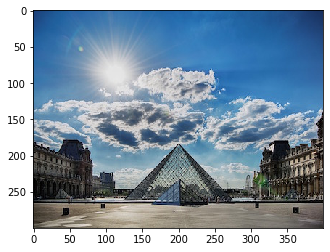

In [3]:
content_image = imageio.imread("content_images/louvre_small.jpg")
imshow(content_image)

In [4]:
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C,shape=[-1])
    a_G_unrolled = tf.reshape(a_G,shape=[-1])
    
    
    J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(((a_C_unrolled-a_G_unrolled)**2))
    
    
    return J_content

In [5]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.7655926


### Computing the style cost


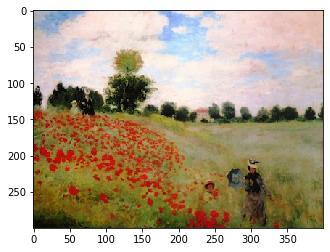

In [6]:
style_image = imageio.imread("style_images/monet.jpg")
imshow(style_image)

In [7]:
def gram_matrix(A):

    GA = A@tf.transpose(A)
    return GA

In [8]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


###  Style cost

In [9]:
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S,shape=(n_H*n_W,n_C)))
    a_G = tf.transpose(tf.reshape(a_G,shape=(n_H*n_W,n_C)))
    
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1/(4*n_C**2*n_W**2*n_H**2))*tf.reduce_sum((GS-GG)**2)
    
    return J_style_layer

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190278


In [11]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [12]:
def compute_style_cost(model, STYLE_LAYERS):
   
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        out = model[layer_name]
        a_S = sess.run(out)

        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style += coeff * J_style_layer

    return J_style

### Defining the total cost to optimize

In [13]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):

    J = alpha*J_content+beta*J_style
    
    return J

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [15]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

Let's load, reshape, and normalize our "content" image (the Louvre museum picture):

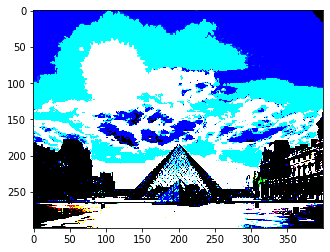

In [16]:
content_image = imageio.imread("content_images/louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)
imshow(np.clip(content_image[0], 0.0, 1.0))


Let's load, reshape and normalize our "style" image (Claude Monet's painting):

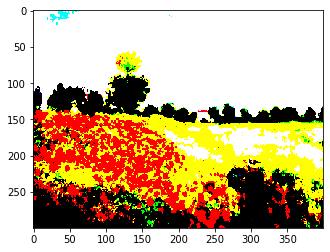

In [17]:
style_image = imageio.imread("style_images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)
imshow(np.clip(style_image[0],0.0,1.0))

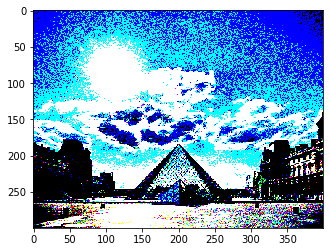

In [18]:
generated_image = generate_noise_image(content_image)
imshow(np.clip(generated_image[0],0.0,1.0))

In [19]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [20]:
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_G = out

J_content = compute_content_cost(a_C, a_G)

In [21]:
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model, STYLE_LAYERS)

In [22]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40) 

In [23]:
# define optimizer
optimizer = tf.train.AdamOptimizer(2.0)

train_step = optimizer.minimize(J)

In [24]:
def model_nn(sess, input_image, num_iterations = 200):
    
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model.
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
        #optimizing a_G
        sess.run(train_step)
        
        # generates the new optimized image
        generated_image = sess.run(model['input'])
        
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            save_image("output/" + str(i) + ".png", generated_image)
    
    
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [ ]:
model_nn(sess,generated_image)

Iteration 0 :
total cost = 5050363000.0
content cost = 7877.684
style cost = 126257096.0
